# Biol 359A  | Principal Component Analysis
### Spring 2023, Week 9
<hr>
Learning Objectives:

  - Understand motivations of dimension reduction
  - Discuss applications towards data visualization and data exploration
  - Interpret the results of a principal component analysis


In [1]:
!git clone https://github.com/BIOL359A-FoundationsOfQBio-Spr23/week9_pca
!mkdir ./data
!cp week9_pca/data/* ./data
!pip install palmerpenguins

Cloning into 'week9_pca'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 22 (delta 8), reused 20 (delta 6), pack-reused 0
Receiving objects: 100% (22/22), 1.25 MiB | 4.47 MiB/s, done.
Resolving deltas: 100% (8/8), done.
mkdir: ./data: File exists
zsh:1: /Library/Frameworks/Python.framework/Versions/2.7/bin/pip: bad interpreter: /Users/jacobevarts/BagheriLab/tumor_vasc_model/tumorcode/venv/bin/python: no such file or directory


In [39]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk
import matplotlib.pyplot as plt

from palmerpenguins import load_penguins

from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

TITLE_FONT = 20
LABEL_FONT = 16
TICK_FONT = 16
FIG_SIZE = (8,8)
COLORS= ["#008080","#CA562C"]

sns.set(font_scale=1.5, rc={'figure.figsize':FIG_SIZE}) 
sns.set_style()
plt.rc("axes.spines", top=False, right=False)


In [3]:
def colorizer(x, y):
    """
    Map x-y coordinates to a rgb color
    """
    r = min(1, 1+y/3)
    b = min(1, 1-y/3)
    g = 1/4 + x/16
    return (r, g, b)

def gen_basic_plot(A, eigen=False):
    xvals = np.linspace(-4, 4, 9)
    yvals = np.linspace(-3, 3, 7)
    xygrid = np.column_stack([[x, y] for x in xvals for y in yvals])

    uvgrid = np.dot(A, xygrid)
    # Map grid coordinates to colors
    colors = list(map(colorizer, xygrid[0], xygrid[1]))

    # Plot grid points 
    plt.scatter(xygrid[0], xygrid[1], s=40, c=colors, edgecolor="none")
    # Set axis limits
    plt.grid(True)
    plt.axis("equal")
    plt.title("Original Grid")
    if eigen:
        eigen_values, eigen_vectors = np.linalg.eig(A)
    
        eig_vec1 = eigen_vectors[:,0]
        eig_vec2 = eigen_vectors[:,1]
        np.set_printoptions(precision=3)
        print(f"Eigen Vector: {eig_vec1} - Eigen Value: {eigen_values[0]:.2f}")
        print(f"Eigen Vector: {eig_vec2} - Eigen Value: {eigen_values[1]:.2f}")
        origin = [0,0]
        plt.quiver(*origin, *eig_vec1, color=['r'], scale=21)
        plt.quiver(*origin, *eig_vec2, color=['b'], scale=21) 


    plt.show()
    plt.scatter(uvgrid[0], uvgrid[1], s=40, c=colors, edgecolor="none")
    # Set axis limits
    plt.grid(True)
    plt.title("Transformed Grid")
    if eigen:
        plt.quiver(*origin, *eig_vec1, color=['r'], scale=21)
        plt.quiver(*origin, *eig_vec2, color=['b'], scale=21)
    plt.axis("equal")
    plt.show()
    

def plot_wrapper(a=2,b=1,c=-1,d=1, eigen=False):
    A = np.column_stack([[a, b], [c, d]])
    gen_basic_plot(A, eigen=eigen)

# Linear Algebra and PCA Example (Questions 1-3)

We are going to start with the following matrix:

$$\begin{bmatrix} 2 & 1 \\ -1 & 1 \\ \end{bmatrix}$$

(This matrix has no real eigen vectors)

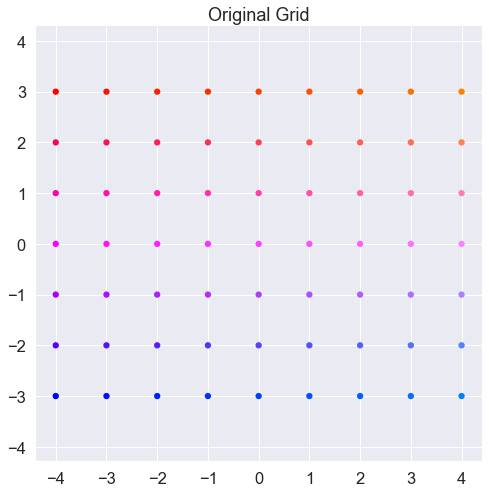

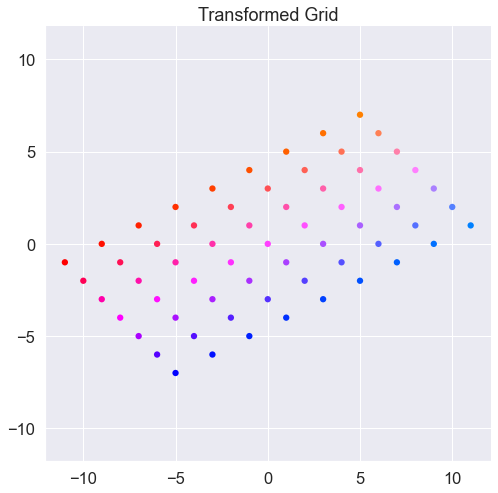

In [4]:
plot_wrapper(a=2,b=1,c=-1,d=1, eigen=False)

This matrix has real eigen vectors:

$$\begin{bmatrix} 5 & 1 \\ 4 & 2 \\ \end{bmatrix}$$

Eigen Vector: [0.97  0.243] - Eigen Value: 6.00
Eigen Vector: [-0.707  0.707] - Eigen Value: 1.00


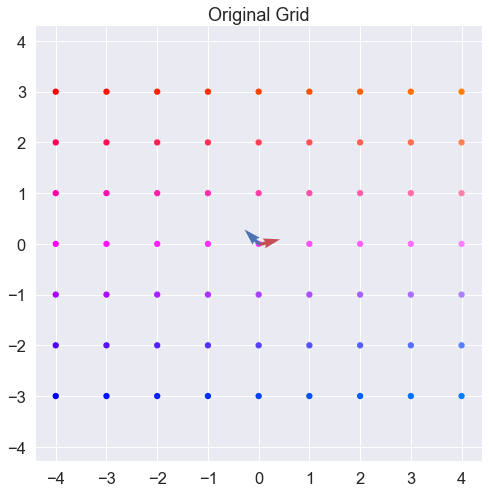

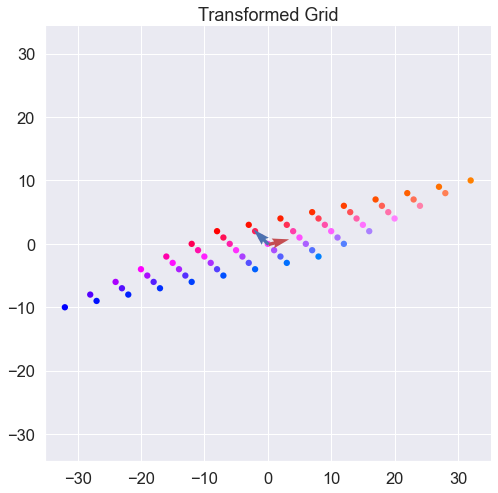

In [5]:
plot_wrapper(a=5, b=1, c=4,d=2, eigen=True)

Introducing the Covariance Matrix:

$$ var(x) = E[(x-\mu_{x})^2] $$
Recall when we defined the covariance:

$$ cov(x,y) = E[x-\mu_{x}]E[y-\mu_{y}] $$

So for example, If I had a data matrix, with N observations, and 3 features - a, b, and c - I will define my covariance matrix $\Sigma$ as:
 
$$ \Sigma = \begin{bmatrix} var(a) & cov(a,b) & cov(a,c)\\ cov(b,a) & var(b)& cov(b,c) \\ cov(c,a) & cov(c,b) & var(c) \end{bmatrix}$$

Which we usually estimate with:

$$ \frac{1}{N-1} XX^T = \hat{\Sigma} $$

(Look familiar? This is the outer product with a normalization factor!)

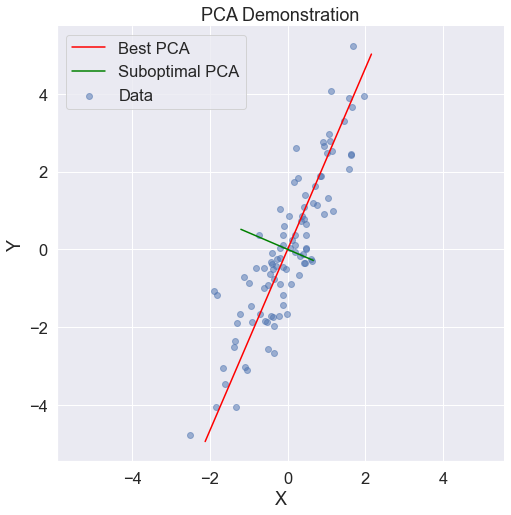

In [6]:
def demonstrate_pca():
    # Sample data
    np.random.seed(42)
    x = np.random.normal(0, 1, 100)
    y = 2 * x + np.random.normal(0, 1, 100)
    data = np.vstack((x, y)).T

    # Centering the data
    centered_data = data - np.mean(data, axis=0)

    # Performing PCA
    cov_matrix = np.cov(centered_data, rowvar=False)
    eig_values, eig_vectors = np.linalg.eig(cov_matrix)

    # Sorting eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eig_values)[::-1]
    eig_values = eig_values[sorted_indices]
    eig_vectors = eig_vectors[:, sorted_indices]

    # Plotting the data
    plt.scatter(centered_data[:, 0], centered_data[:, 1], alpha=0.5, label='Data')

    # Plotting the best PCA direction
    best_direction = eig_vectors[:, 0]
    projected_data = np.dot(centered_data, best_direction)
    max_value = np.max(projected_data)
    min_value = np.min(projected_data)
    t = np.linspace(min_value, max_value, 100)
    plt.plot(t * best_direction[0], t * best_direction[1], color='red', label='Best PCA')

    # Plotting a suboptimal direction
    suboptimal_direction = eig_vectors[:, 1]
    projected_data = np.dot(centered_data, suboptimal_direction)
    max_value = np.max(projected_data)
    min_value = np.min(projected_data)
    t = np.linspace(min_value, max_value, 100)
    plt.plot(t * suboptimal_direction[0], t * suboptimal_direction[1], color='green', label='Suboptimal PCA')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('PCA Demonstration')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Calling the function
demonstrate_pca()

## Generate a toy dataset

Notice the direction where the most variance occurs. This line will be slightly different from our linear regression line, because in PCA we're treating these variables the same. (We care about the error in both the x and y direction, rather than simply the y-direction).

We then generate the eigen vector of our covariance matrix, and plot it over the original data. 

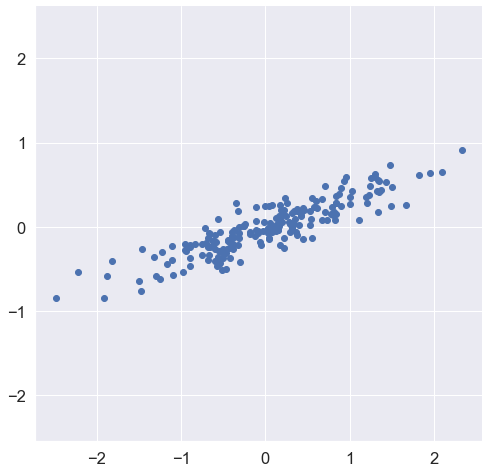

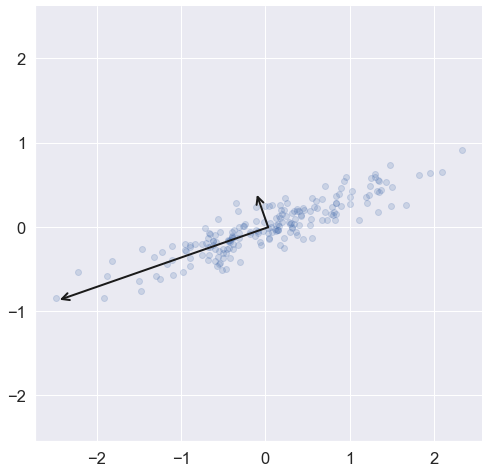

In [7]:
def example_pca():
    rng = np.random.RandomState(1)
    X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
    plt.scatter(X[:, 0], X[:, 1])
    plt.axis('equal')
    plt.show()
    pca = PCA(n_components=2)
    pca.fit(X)
    
    # plot data
    plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
    for length, vector in zip(pca.explained_variance_, pca.components_):
        v = vector * 3 * np.sqrt(length)
        draw_vector(pca.mean_, pca.mean_ + v)
    plt.axis('equal'); 
    plt.show()
    
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    color='k',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

example_pca()

### Coordinate System
Now that we have the eigenvectors, we can do two things with them.
First, we're going to look at using them as a new coordinate system.

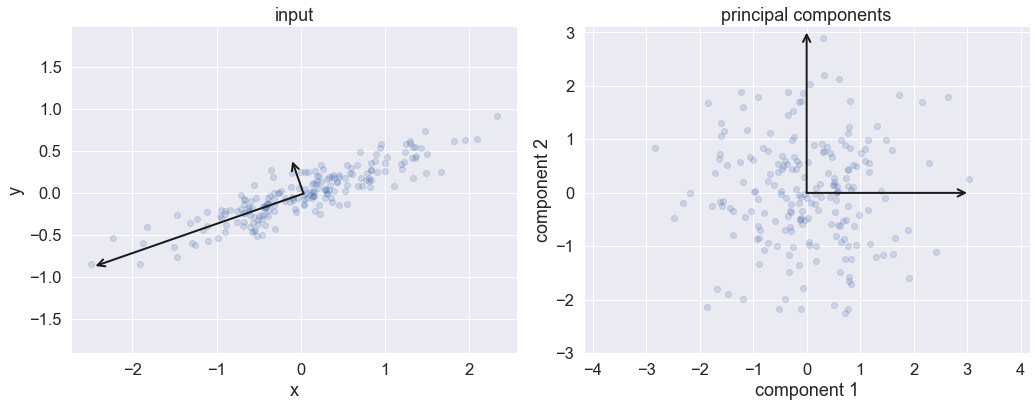

In [8]:
def coordinatesystem_example():
    rng = np.random.RandomState(1)
    X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
    pca = PCA(n_components=2, whiten=True)
    pca.fit(X)

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.15)

    # plot data
    ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
    for length, vector in zip(pca.explained_variance_, pca.components_):
        v = vector * 3 * np.sqrt(length)
        draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
    ax[0].axis('equal');
    ax[0].set(xlabel='x', ylabel='y', title='input')

    # plot principal components
    X_pca = pca.transform(X)
    ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
    draw_vector([0, 0], [0, 3], ax=ax[1])
    draw_vector([0, 0], [3, 0], ax=ax[1])
    ax[1].axis('equal')
    ax[1].set(xlabel='component 1', ylabel='component 2',
              title='principal components',
              xlim=(-5, 5), ylim=(-3, 3.1))
coordinatesystem_example()

### Projection
The other option we have is to simply use one principal component, and represent our data with one vector rather than two. What does this accomplish? 

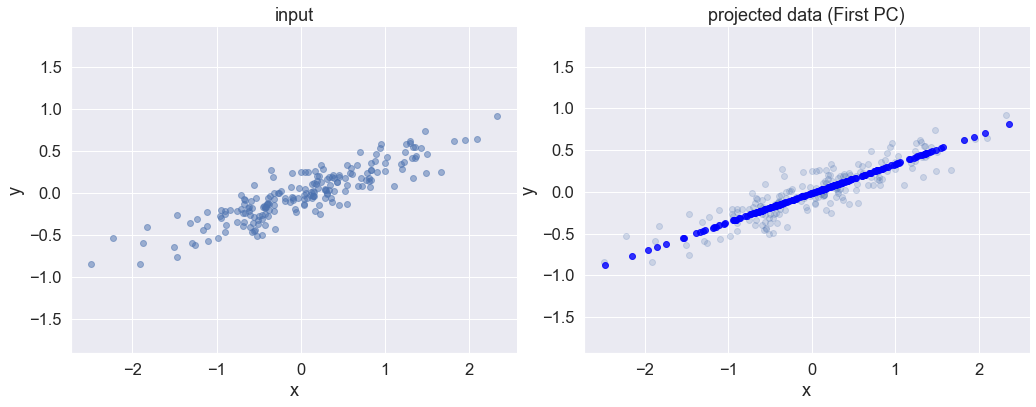

In [9]:
def projection_example():
    rng = np.random.RandomState(1)
    X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
    pca = PCA(n_components=2, whiten=True)
    pca.fit(X)

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.15)

    # plot data
    ax[0].scatter(X[:, 0], X[:, 1], alpha=0.5)
    ax[0].axis('equal');
    ax[0].set(xlabel='x', ylabel='y', title='input')

    # plot principal components
    pca = PCA(n_components=1, whiten=True)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_new = pca.inverse_transform(X_pca)
    ax[1].scatter(X[:, 0], X[:, 1], alpha=0.2)
    ax[1].scatter(X_new[:, 0], X_new[:, 1], color="blue", alpha=0.8)
    ax[1].axis('equal')
    ax[1].set(xlabel='x', ylabel='y',
              title='projected data (First PC)')
    
projection_example()

In [10]:
def PerformPCA(X, n_dimensions=10, plot=True):
    """
    Uses sklearn PCA tool to perform PCA
    input:
    X: Pandas Dataframe or Numpy Array of features
    n_dimensions: Number of PCs to fit
    
    output:
    X_pca: Pandas dataframe with column titles of PC1,...,PCn
    """
    X_standardized = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_dimensions)
    pca.fit(X_standardized)
    X_pca_array = pca.transform(X_standardized)
    column_names = ['PC{}'.format(i+1) for i in range(n_dimensions)] 
    X_pca = pd.DataFrame(X_pca_array, columns=column_names)
    if plot:
        plt.plot(column_names, np.cumsum(pca.explained_variance_ratio_), 'o--')
        plt.title('Scree Plot', fontsize=TITLE_FONT)
        plt.xlabel('Number of PCs', fontsize=LABEL_FONT)
        plt.ylabel('Total Percent Variance Explained', fontsize=LABEL_FONT)
        plt.ylim(0,1)
        plt.show()
    return X_pca

# Now we are going to explore a couple datasets that we've looked at before with PCA (Question 4 + 5)
The first dataset we'll look at is penguin characterstics

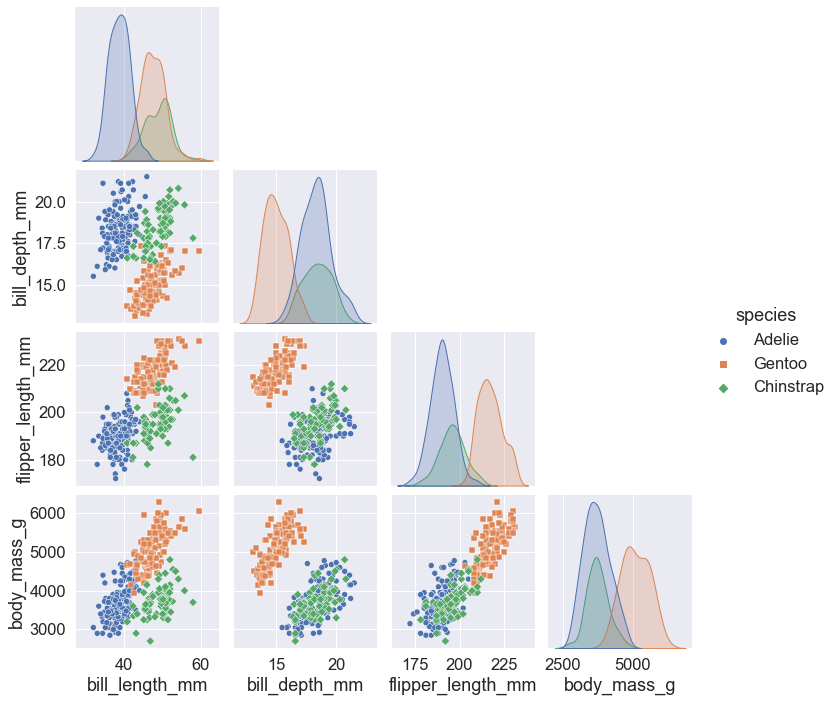

In [11]:
penguins=load_penguins()
penguins.dropna(inplace=True)
features=["bill_length_mm", "bill_depth_mm", "flipper_length_mm","body_mass_g"]
label='species'
sns.pairplot(penguins, vars=features, corner=True, hue="species", markers=["o", "s", "D"])

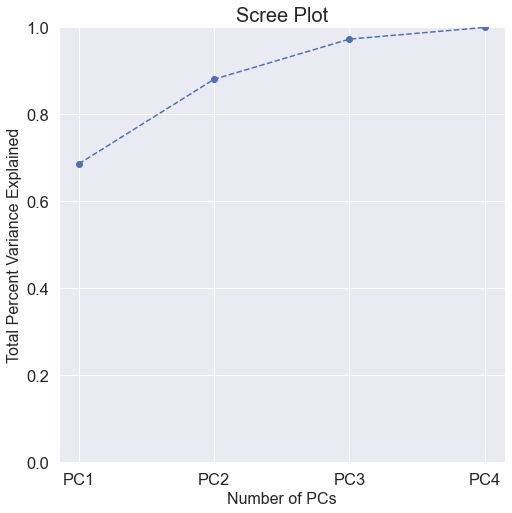

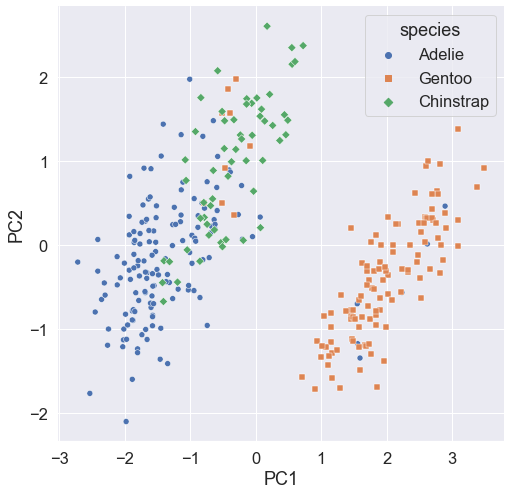

In [12]:
penguins_X = penguins[features]
penguins_y = penguins[label]
penguins_PCA_df = PerformPCA(penguins_X, n_dimensions=4)
penguins_PCA_df = penguins_PCA_df.join(penguins_y)
sns.scatterplot(x='PC1',y='PC2',hue='species',data=penguins_PCA_df,style='species',markers=["o", "s", "D"])
plt.show()

Looking at the penguin plot of PC1 vs. PC2, we can see that we can visualize and seperate the penguins reasonably well even though we went from 4 features (bill length, bill depth, flipper length, body mass) down to 2 features on the chart (PC1, PC2). 

<AxesSubplot:xlabel='species', ylabel='PC1'>

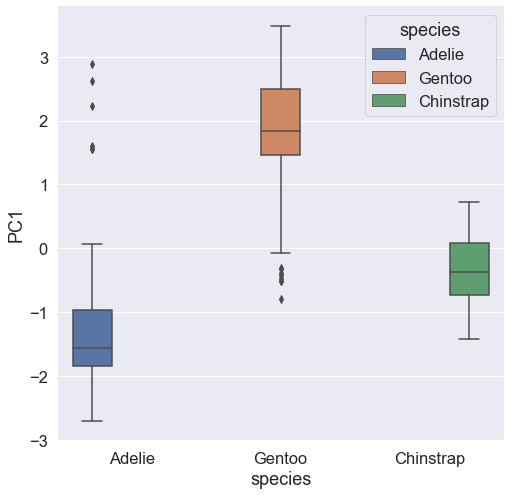

In [13]:
sns.boxplot(x="species", y="PC1", hue="species",
                 data=penguins_PCA_df)

<AxesSubplot:xlabel='species', ylabel='PC2'>

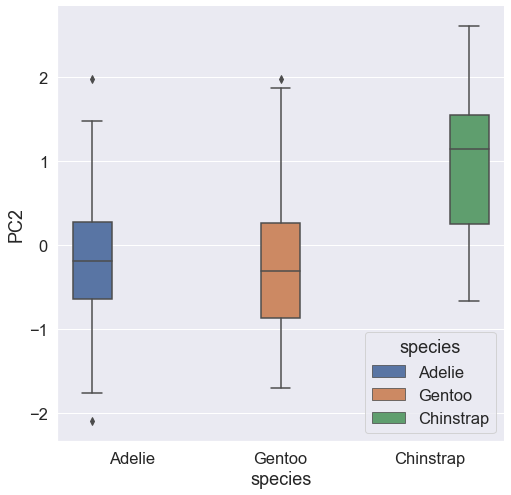

In [14]:
sns.boxplot(x="species", y="PC2", hue="species",
                 data=penguins_PCA_df)

# We are going to look at our trusty breast cancer dataset (Question 6 - 9)

Remember, we could build fairly effective classification models with this dataset.

In [15]:
cancer_raw = load_breast_cancer()
print(cancer_raw.DESCR)
tumor_features = pd.DataFrame(cancer_raw.data, columns=cancer_raw.feature_names)
tumor = pd.DataFrame(cancer_raw.target, columns=['tumor'])
tumor_nominal = tumor.replace({'tumor': {0: 'benign', 1: 'malignant'}})
cancer_df = pd.concat([tumor_features, tumor_nominal], axis=1)
tumor_features.describe()

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


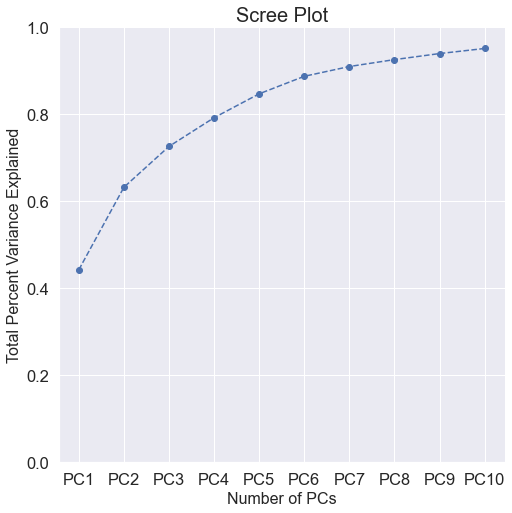

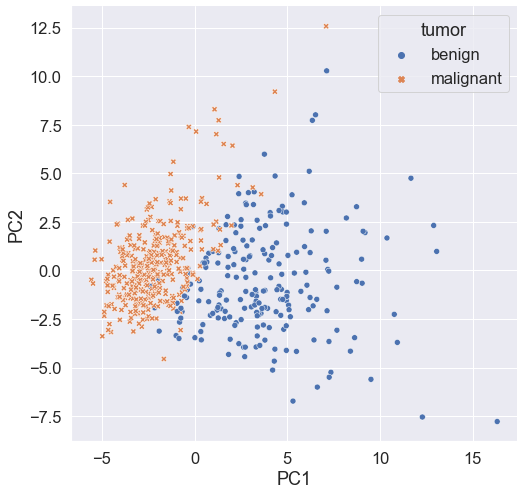

In [16]:
PCA_df = PerformPCA(tumor_features)
PCA_df = PCA_df.join(tumor_nominal)
sns.scatterplot(x='PC1',y='PC2',style='tumor',hue='tumor',data=PCA_df,markers=True)
plt.show()

But if I plot different PCs...

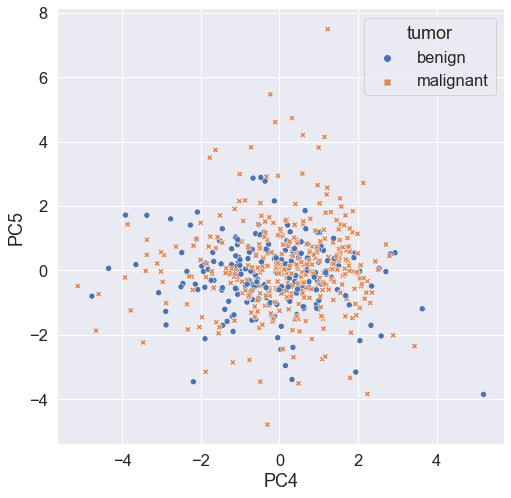

In [17]:
sns.scatterplot(x='PC4',y='PC5',style='tumor',hue='tumor',data=PCA_df,markers=True)
plt.show()

Now we can look at how are features combine to make our principal components

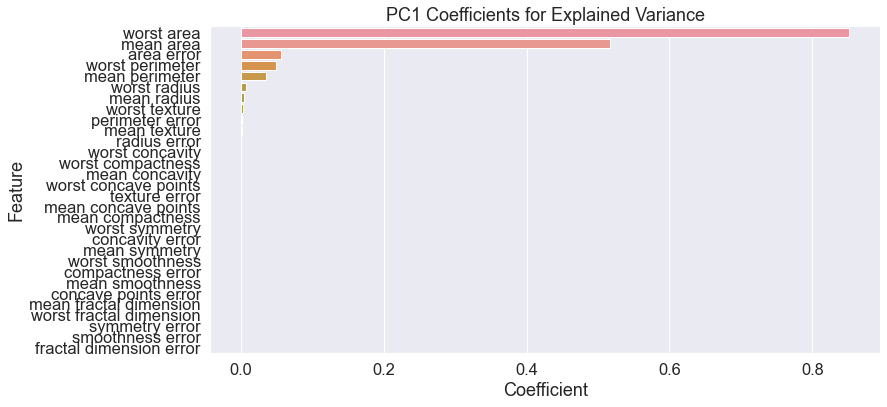

In [23]:
# Perform PCA on the dataset
pca = PCA()
pca.fit(tumor_features)

# Get the PC vector coefficients for the first principal component (PC1)
pc1_coefficients = pca.components_[0]

# Create a DataFrame to store the coefficients and corresponding feature names
coefficients_df = pd.DataFrame({'Feature': tumor_features.columns, 'Coefficient': pc1_coefficients})

# Sort the coefficients in descending order based on absolute values
sorted_coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

# Plot the coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=sorted_coefficients_df)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('PC1 Coefficients for Explained Variance')
plt.show()

# LDA

Here we will look at linear discriminant analysis (LDA). Remember that LDA is similar to PCA in that it is projecting the data onto a new axis. Rather than projecting onto the axis that accounts for the most variance in the data, LDA projects on the axis that does the best job seperating the data.

Accuracy: 0.96


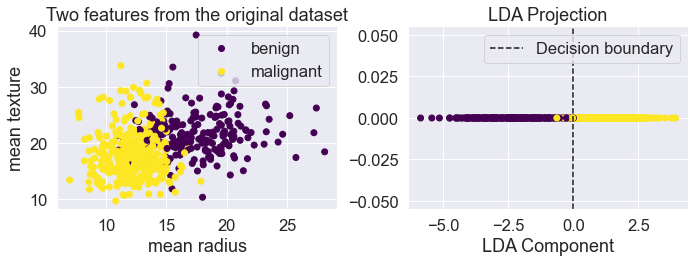

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the breast cancer dataset
cancer_raw = load_breast_cancer()

# Prepare the dataset
tumor_features = pd.DataFrame(cancer_raw.data, columns=cancer_raw.feature_names)
tumor = pd.DataFrame(cancer_raw.target, columns=['tumor'])
tumor_nominal = tumor.replace({'tumor': {0: 'benign', 1: 'malignant'}})
cancer_df = pd.concat([tumor_features, tumor_nominal], axis=1)

X_train, X_test, y_train, y_test = train_test_split(tumor_features, tumor.values.ravel(), test_size=0.2, random_state=42)

# Perform LDA
lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)

# Predict tumor class on the test set
X_test_lda = lda.transform(X_test)
y_pred = lda.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

X_lda = lda.fit_transform(tumor_features, tumor.values.ravel())

# Plot the original data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
scatter = plt.scatter(tumor_features.iloc[:, 0], tumor_features.iloc[:, 1], c=tumor.values.ravel(), cmap='viridis')
plt.xlabel(tumor_features.columns[0])
plt.ylabel(tumor_features.columns[1])
plt.legend(handles=scatter.legend_elements()[0], labels=['benign', 'malignant'])
plt.title('Two features from the original dataset')

# Plot the LDA projection
plt.subplot(1, 2, 2)
plt.scatter(X_lda, np.zeros_like(X_lda), c=tumor.values.ravel(), cmap='viridis')
plt.axvline(x=0, color='k', linestyle='--', label='Decision boundary')
plt.legend()
plt.xlabel('LDA Component')
plt.title('LDA Projection')

plt.tight_layout()
plt.show()